# Data Preparation

In [1]:
# Importing the necessary libraries
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
from torchsummary import summary
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch.optim as optim
from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
from sklearn.preprocessing import MinMaxScaler
torch.manual_seed(0) # Set for testing purposes, please do not change!

<h2> Data Loading and Data Cleansing</h2>

In [2]:
# Downloading and Loading FashionMNIST dataset

transform = transforms.Compose([transforms.ToTensor()])


train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


# train_data = train_data.data.numpy()
# test_data = test_data.data.numpy()

training_images = np.zeros((len(train_data), 28, 28))
training_labels = np.zeros(len(train_data), dtype=int)

for i, (img, label) in enumerate(train_data):
    training_images[i] = img.numpy()
    training_labels[i] = int(label)

testing_images = np.zeros((len(test_data), 28, 28))
testing_labels = np.zeros(len(test_data), dtype = int)

for i, (img, label) in enumerate(test_data):
    testing_images[i] = img.numpy()
    testing_labels[i] = int(label)
print('Training Data: X=%s, y=%s' % (training_images.shape, training_labels.shape))
print('Testing Data : X=%s, y=%s' % (testing_images.shape, testing_labels.shape))

Training Data: X=(60000, 28, 28), y=(60000,)
Testing Data : X=(10000, 28, 28), y=(10000,)


In [3]:
# Data Cleansing
np.isnan(training_images).any()
np.isnan(training_labels).any()

# NORMALIZATION
X_train_all = training_images.astype('float32')/255
X_test  = testing_images.astype('float32')/255

<h2>Data Splitting</h2>

In [4]:
# Splitting the training dataset to train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train_all, training_labels, stratify=training_labels, test_size=0.2, random_state=42)

print("Splitting the training dataset into training and validation (80% Train and 20% Validation)")
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('val  : X=%s, y=%s' % (X_val.shape, y_val.shape))
print('Test : X=%s, y=%s' % (X_test.shape, testing_labels.shape))

Splitting the training dataset into training and validation (80% Train and 20% Validation)
Train: X=(48000, 28, 28), y=(48000,)
val  : X=(12000, 28, 28), y=(12000,)
Test : X=(10000, 28, 28), y=(10000,)


# Exploratory Data Analysis

<h2> Descriptive Statistics</h2>

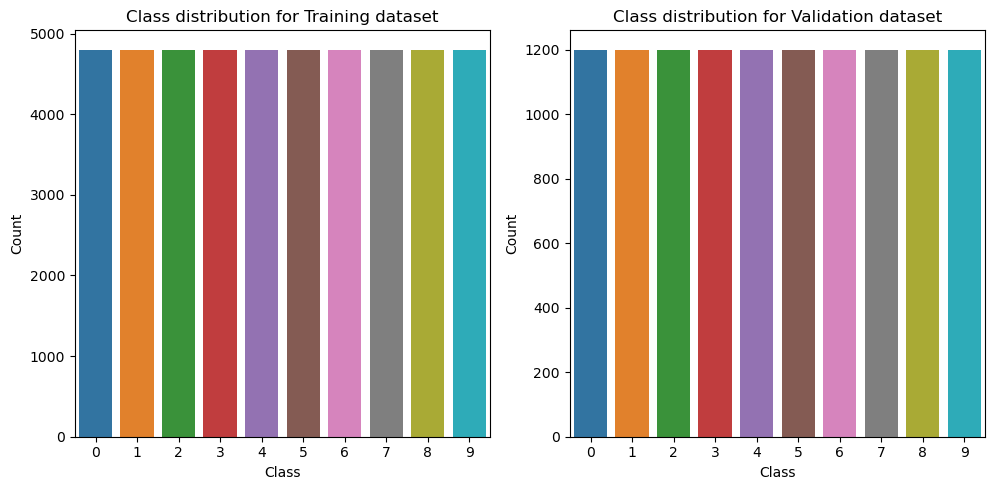

In [5]:
import seaborn as sns
import pandas as pd

# Create separate Series for each dataset
y_train_series = pd.Series(y_train)
y_val_series = pd.Series(y_val)
testing_labels_series = pd.Series(testing_labels)

# Calculate value counts for each dataset
class_counts_train = y_train_series.value_counts()
class_counts_val = y_val_series.value_counts()
class_counts_test = testing_labels_series.value_counts()

# Plotting class distributions for each dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=class_counts_train.index, y=class_counts_train.values)
plt.title("Class distribution for Training dataset")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
sns.barplot(x=class_counts_val.index, y=class_counts_val.values)
plt.title("Class distribution for Validation dataset")
plt.xlabel("Class")
plt.ylabel("Count")



plt.tight_layout()
plt.show()


<h2> Data Visualization </h2>

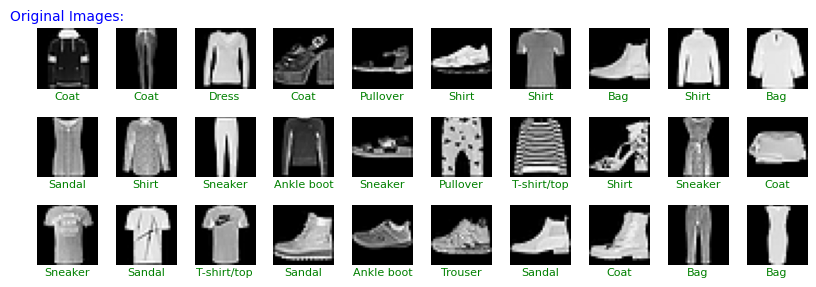

In [6]:
# Visualizing Plot examples from classes
import matplotlib.pyplot as plt

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Randomly select 30 images from train dataset to visualize
num_images_to_display = 30
random_indexes = np.random.randint(0, X_train.shape[0], num_images_to_display)

# Create a figure with a grid of subplots
plt.figure(figsize=(8, 6))  # Adjust overall figure size

for i, index in enumerate(random_indexes, 1):
    # Original image
    plt.subplot(6, 10, i)
    plt.imshow(training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Original Images:", fontsize=10, color='blue')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')



# Adjust the placement of the title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


<h3> Principal Component Analysis (Dimensionality Reduction) </h2>

In [7]:
# Flatten the images to 1-D by reshaping
X_train_all = X_train_all.reshape(60000,784)
X_train = X_train.reshape(48000,784)
X_val   = X_val.reshape(12000,784)
X_test  = X_test.reshape(10000,784)

print("Training and validation matrix combined shape  :", X_train_all.shape)
print("Training matrix shape  :", X_train.shape)
print("Validation matrix shape:", X_val.shape)
print("Test matrix shape      :", X_test.shape)


# Performing PCA on both training and validation data combined
from sklearn.decomposition import PCA
pca_all = PCA(n_components = 784)
# Fit on training data
pca_fit = pca_all.fit_transform(X_train_all)
#percentage variance explained
ratio_variance = np.cumsum(pca_all.explained_variance_ratio_)
pca_fit.shape

Training and validation matrix combined shape  : (60000, 784)
Training matrix shape  : (48000, 784)
Validation matrix shape: (12000, 784)
Test matrix shape      : (10000, 784)


(60000, 784)

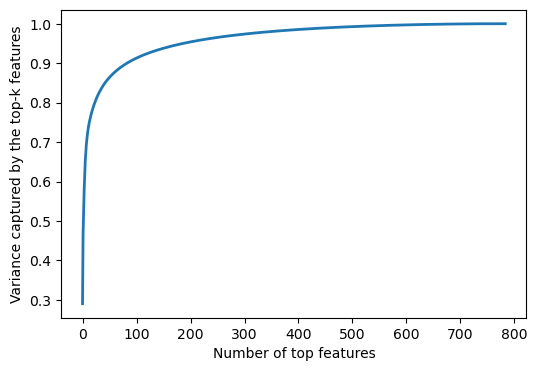

In [8]:
# Plot the PCA spectrum
plt.figure(figsize=(6, 4))
plt.plot(ratio_variance, linewidth=2)
plt.xlabel("Number of top features")
plt.ylabel("Variance captured by the top-k features")
plt.show()

In [9]:
pca = PCA(n_components=0.95)
pca.fit(X_train)
pca.n_components_

187

<Axes: >

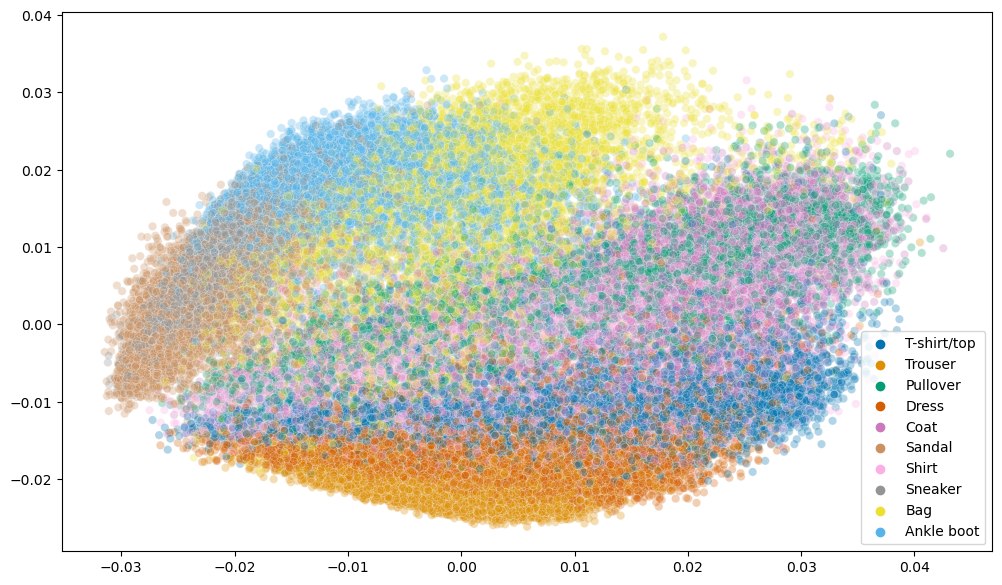

In [10]:
label_mapping = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

def map_to_label(value):
    return label_mapping.get(int(value), 'Unknown')

# Apply the mapping function element-wise to the array
labels = np.vectorize(map_to_label)(training_labels)

# Plotting the data based on first two principle components
plt.figure(figsize=(12,7))
import seaborn as sns
sns.scatterplot(
    x=pca_fit[:,0], y=pca_fit[:,1],
    hue = labels,
    hue_order = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    palette=sns.color_palette("colorblind", 10),
    legend="full",
    alpha=0.3
)

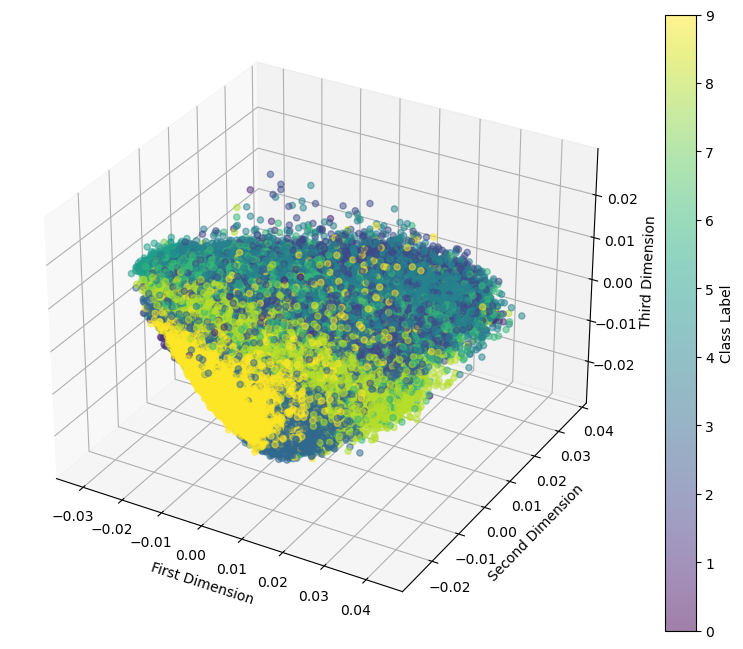

In [11]:
# Plotting the data based on first three principle components
from sklearn.preprocessing import LabelEncoder

# Use LabelEncoder to convert string labels to numeric values
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Plotting the data based on first three principle components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    xs=pca_fit[:, 0], ys=pca_fit[:, 1], zs=pca_fit[:, 2],
    c=numeric_labels,  # Use numeric labels for coloring
    cmap='viridis',  # You can choose a different colormap
    alpha=0.5
)

ax.set_xlabel('First Dimension')
ax.set_ylabel('Second Dimension')
ax.set_zlabel('Third Dimension')

# Create a colorbar
cb = plt.colorbar(scatter, ax=ax)
cb.set_label('Class Label')

plt.show()


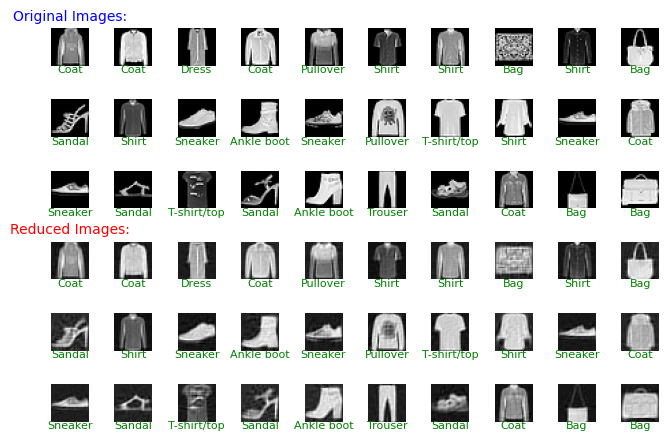

In [12]:
# Reshaping the Data into original size
X_train_t = pca.transform(X_train)
X_val_t   = pca.transform(X_val)
X_test_t  = pca.transform(X_test)

X_train_i = pca.inverse_transform(X_train_t)
X_val_i   = pca.inverse_transform(X_val_t)
X_test_i  = pca.inverse_transform(X_test_t)


training_images         = X_train.reshape(48000,28,28)
reduced_training_images = X_train_i.reshape(48000,28,28)

# Plotting the data after PCA
for i, index in enumerate(random_indexes, 1):
    # Original image
    plt.subplot(6, 10, i)
    plt.imshow(training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Original Images:", fontsize=10, color='blue')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')

    # Reduced image
    plt.subplot(6, 10, i + num_images_to_display)
    plt.imshow(reduced_training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Reduced Images:", fontsize=10, color='red')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')

# Adjust the placement of the title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<h3> t-Distributed Stochastic Neighbouring Entities (t-SNE)</h3>

<Axes: >

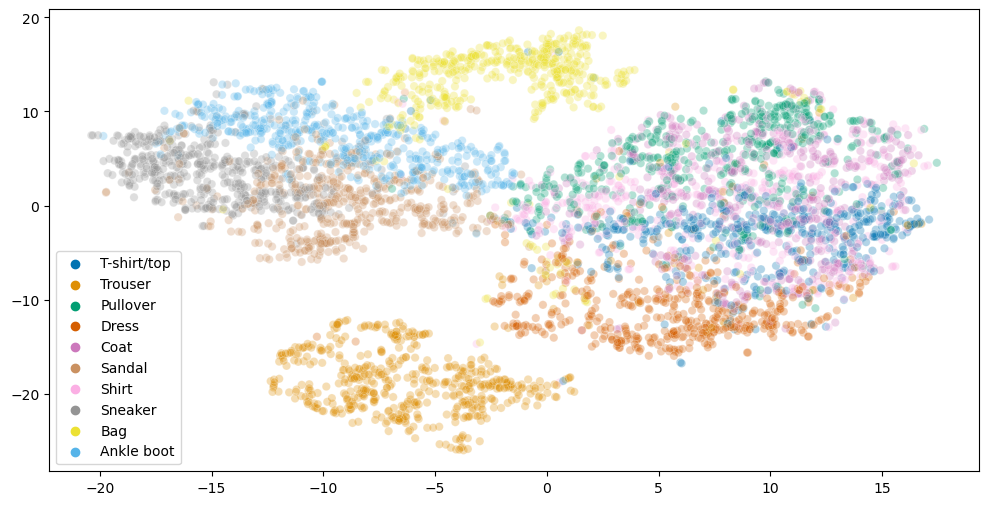

In [13]:
from sklearn.manifold import TSNE

# Invoking the t-SNE method
tsne = TSNE(n_components=3)
tsne_dt = X_train_all[:5000]
tsne_results = tsne.fit_transform(tsne_dt)

plt.figure(figsize=(12,6))
sns.scatterplot(x = tsne_results[:,0],
    y = tsne_results[:,1],
    hue=labels[:5000],
    hue_order = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    palette=sns.color_palette("colorblind", 10),
    legend="full",
    alpha=0.3)

<h1> Model 1 (Dense Neural Network - DNN)

In [14]:
# Building the Dense Neural Network
class FNN(nn.Module):
    def __init__(self, nodes_per_layer, activation_function ):
        super().__init__()

        layers = []
        for i in range(len(nodes_per_layer)-2):
            layers.append(nn.Linear(nodes_per_layer[i], nodes_per_layer[i+1]))

            if activation_function == 'relu':
                layers.append(nn.ReLU())
            else:
                layers.append(nn.LeakyReLU(0.1))
        layers.append(nn.Linear(nodes_per_layer[len(nodes_per_layer)-2], nodes_per_layer[len(nodes_per_layer)-1]))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [15]:
# Creating TensorDatasets and DataLoaders
X_train_fnn = torch.tensor(X_train_t).float()
y_train_fnn = torch.tensor(y_train).long()
X_val_fnn   = torch.tensor(X_val_t).float()
y_val_fnn   = torch.tensor(y_val).long()
X_test_fnn  = torch.tensor(X_test_t).float()
y_test_fnn  = torch.tensor(testing_labels).long()


train_dataset = TensorDataset(X_train_fnn, y_train_fnn)
val_dataset   = TensorDataset(X_val_fnn, y_val_fnn)
test_dataset  = TensorDataset(X_test_fnn, y_test_fnn)

In [16]:
# Function to train and evaluate the model for a given combination of hyperparameters
def train_and_evaluate(nodes_per_layer, activation_function, optimizer, batch_size, model_count):

    # Create the DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create the model
    model = FNN(nodes_per_layer, activation_function)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters())
    else:
        optimizer = optim.RMSprop(model.parameters())

    # Training loop
    best_val_accuracy = 0.0
    best_val_loss     = 0.0
    best_train_acc    = 0.0
    best_train_loss   = 0.0
    num_epochs        = 30
    train_losses      = []
    val_losses        = []
    train_accuracies  = []
    val_accuracies    = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train_preds += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        train_accuracy = correct_train_preds / len(train_dataset)
        train_accuracies.append(train_accuracy)

        # Evaluate model on Validation dataset
        model.eval()
        running_val_loss = 0.0
        correct_val_preds = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item() * val_inputs.size(0)

                _, predicted = torch.max(val_outputs, 1)
                correct_val_preds += (predicted == val_labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        val_accuracy = correct_val_preds / len(val_dataset)
        val_accuracies.append(val_accuracy)

        # Save the model on epoch with best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_val_loss     = epoch_val_loss
            best_train_acc    = train_accuracy
            best_train_loss   = epoch_train_loss
            torch.save(model.state_dict(), 'best_fnn_model'+str(model_count)+'.pth')

    return best_val_accuracy, best_val_loss, best_train_acc,best_train_loss, train_losses, val_losses, train_accuracies, val_accuracies

In [17]:
# Defining the hyperparameters to tune
hyperparameters = {
    'nodes_per_layer': [[187,64,10], [187,64,32,10]],
    'activation_function': ['relu'],
    'optimizer': ['Adam', 'RMSprop'],
    'batch_size': [32, 64]
}

model_count           = 0
best_val_acc          = 0.0
best_val_loss         = 0.0
best_train_acc        = 0.0
best_train_loss       = 0.0
best_model            = 0
best_train_losses     = []
best_val_losses       = []
best_train_accuracies = []
best_val_accuracies   = []
best_hyperparameters  = {
                            'nodes_per_layer': [187,64,10],
                            'activation_function': 'relu',
                            'optimizer': 'Adam',
                            'batch_size': 32
                        }

# Hyper parameter tuning
for nodes_per_layer in hyperparameters['nodes_per_layer']:
  for activation_function in hyperparameters['activation_function']:
    for optimizer in hyperparameters['optimizer']:
      for batch_size in hyperparameters['batch_size']:
        val_acc, val_loss, train_acc, train_loss, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(nodes_per_layer, activation_function,optimizer, batch_size, model_count)
        print("Model ")
        print("Nodes for layers:", nodes_per_layer)
        print("Optimizer:", optimizer)
        print("Batch Size:", batch_size)
        print("Training accuracy:", train_acc, "Validation accuracy:", val_acc)
        print("\n")
        if val_acc > best_val_acc:
          best_val_acc                                 = val_acc
          best_val_loss                                = val_loss
          best_train_acc                               = train_acc
          best_train_loss                              = train_loss
          best_hyperparameters['nodes_per_layer']      = nodes_per_layer
          best_hyperparameters['activation_function']  = activation_function
          best_hyperparameters['optimizer']            = optimizer
          best_hyperparameters['batch_size']           = batch_size
          best_train_losses                            = train_losses
          best_val_losses                              = val_losses
          best_train_accuracies                        = train_accuracies
          best_val_accuracies                          = val_accuracies

          best_model = model_count
        model_count = model_count + 1

Model 
Nodes for layers: [187, 64, 10]
Optimizer: Adam
Batch Size: 32
Training accuracy: 0.8554375 Validation accuracy: 0.8584166666666667


Model 
Nodes for layers: [187, 64, 10]
Optimizer: Adam
Batch Size: 64
Training accuracy: 0.8501458333333334 Validation accuracy: 0.8545


Model 
Nodes for layers: [187, 64, 10]
Optimizer: RMSprop
Batch Size: 32
Training accuracy: 0.8381458333333334 Validation accuracy: 0.8425833333333334


Model 
Nodes for layers: [187, 64, 10]
Optimizer: RMSprop
Batch Size: 64
Training accuracy: 0.8510416666666667 Validation accuracy: 0.8563333333333333


Model 
Nodes for layers: [187, 64, 32, 10]
Optimizer: Adam
Batch Size: 32
Training accuracy: 0.8571458333333334 Validation accuracy: 0.85875


Model 
Nodes for layers: [187, 64, 32, 10]
Optimizer: Adam
Batch Size: 64
Training accuracy: 0.8469375 Validation accuracy: 0.84925


Model 
Nodes for layers: [187, 64, 32, 10]
Optimizer: RMSprop
Batch Size: 32
Training accuracy: 0.10027083333333334 Validation accuracy: 0

Best hyperparameters:
Nodes for layers: [187, 64, 32, 10]
Optimizer: RMSprop
Batch Size: 64
Best model path     : best_fnn_model7.pth




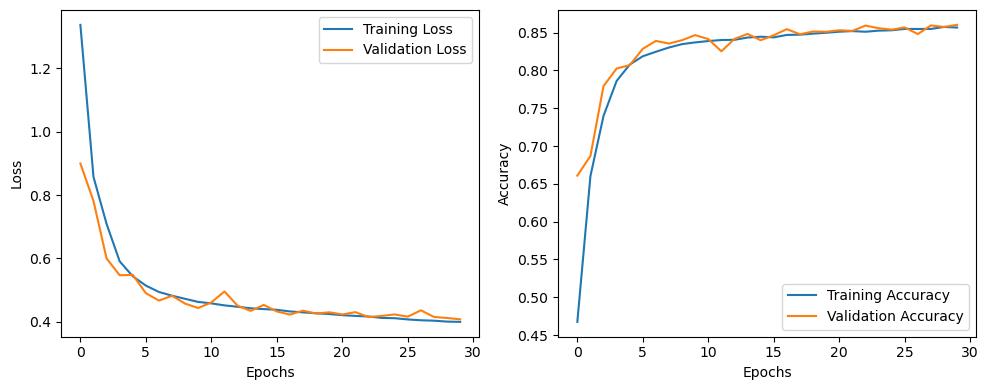

Training loss on best FNN model      : 0.39991570832331974

Training accuracy on best FNN model  : 0.8567916666666666

Validation loss on best FNN model    : 0.40788972429434456

Validation accuracy on best FNN model: 0.8603333333333333



In [18]:
# Printing Best hyperparameters
print(f"Best hyperparameters:")
print("Nodes for layers:", best_hyperparameters['nodes_per_layer'])
print("Optimizer:", best_hyperparameters['optimizer'])
print("Batch Size:", best_hyperparameters['batch_size'])

# Print the best model file path
best_model_path = 'best_fnn_model'+ str(best_model) + '.pth'
print(f"Best model path     : {best_model_path}\n\n")

# Plotting training history for the best FNN model
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_train_accuracies, label='Training Accuracy')
plt.plot(best_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Print training, validation losses and accuracies on best FNN model

print(f"Training loss on best FNN model      : {best_train_loss}\n")
print(f"Training accuracy on best FNN model  : {best_train_acc}\n")
print(f"Validation loss on best FNN model    : {best_val_loss}\n")
print(f"Validation accuracy on best FNN model: {best_val_acc}\n")


In [19]:
#Evaluating of best model on test dataset

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics


# Initialize your neural network class
model = FNN(best_hyperparameters['nodes_per_layer'], best_hyperparameters['activation_function'])
# Load the saved best model weights
model.load_state_dict(torch.load(best_model_path))

test_loader = DataLoader(test_dataset, batch_size=best_hyperparameters['batch_size'], shuffle=False)

# Set the model to evaluation mode
model.eval()

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate the confusion matrix and accuracy
conf_matrix = confusion_matrix(true_labels, predictions)
print("Classification report for best FNN on test dataset :\n%s\n"
      % (metrics.classification_report(true_labels, predictions)))

print("\nConfusion Matrix on Test dataset:")
print(conf_matrix)

Classification report for best FNN on test dataset :
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1000
           1       0.94      0.97      0.95      1000
           2       0.72      0.78      0.75      1000
           3       0.83      0.86      0.84      1000
           4       0.75      0.78      0.76      1000
           5       0.93      0.94      0.93      1000
           6       0.67      0.54      0.60      1000
           7       0.91      0.94      0.92      1000
           8       0.98      0.93      0.95      1000
           9       0.96      0.93      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000



Confusion Matrix on Test dataset:
[[813   9  22  58   4   2  87   0   5   0]
 [  4 966   6  21   3   0   0   0   0   0]
 [ 22  13 780  13 121   0  50   0   1   0]
 [ 33  29  11 858  30  

<h1> Model 2 (Convolutional Neural Network - CNN)

In [24]:
# Building the Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, conv_block_channels, activation='relu', num_classes=10):
        super(CNN, self).__init__()

        activation_func = nn.ReLU(inplace=True) if activation == 'relu' else nn.LeakyReLU(0.2, inplace=True)

        layers = []
        in_channels = 1  # Input channel for FashionMNIST
        for i in range(len(conv_block_channels)-1):
            layers.append(nn.Conv2d(in_channels,conv_block_channels[i], kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(conv_block_channels[i]))
            layers.append(activation_func)
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = conv_block_channels[i]
        layers.append(nn.Conv2d(in_channels,conv_block_channels[len(conv_block_channels)-1], kernel_size=3, padding=1))

        self.cnn = nn.Sequential(*layers)

        # Calculating the output size after the convolutional layers
        # Use a dummy tensor to infer the shape after the convolutions and poolings
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)
            dummy_output = self.cnn(dummy_input)
            _, output_channels, output_height, output_width = dummy_output.size()

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(output_channels * output_height * output_width, 256),
            activation_func,
            nn.Linear(256, 128),
            activation_func,
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        return self.fc_layers(x)


In [25]:
# Creating TensorDatasets and DataLoaders
X_train_cnn = torch.tensor(X_train.reshape(-1,1,28,28)).float()
y_train_cnn = torch.tensor(y_train).long()
X_val_cnn   = torch.tensor(X_val.reshape(-1,1,28,28)).float()
y_val_cnn   = torch.tensor(y_val).long()
X_test_cnn  = torch.tensor(X_test.reshape(-1,1,28,28)).float()
y_test_cnn  = torch.tensor(testing_labels).long()


train_dataset = TensorDataset(X_train_cnn, y_train_cnn)
val_dataset   = TensorDataset(X_val_cnn, y_val_cnn)
test_dataset  = TensorDataset(X_test_cnn, y_test_cnn)

In [26]:
# Function to train and evaluate the model for a given combination of hyperparameters
def train_and_evaluate(conv_block_channels, activation_function, optimizer, batch_size, model_count):

    # Create the DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create the model
    model = CNN(conv_block_channels, activation_function)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters())
    else:
        optimizer = optim.RMSprop(model.parameters())

    # Training loop
    best_val_accuracy = 0.0
    best_val_loss     = 0.0
    best_train_acc    = 0.0
    best_train_loss   = 0.0
    num_epochs        = 10
    train_losses      = []
    val_losses        = []
    train_accuracies  = []
    val_accuracies    = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train_preds += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracy = correct_train_preds / len(train_dataset)
        train_accuracies.append(train_accuracy)

        # Evaluate model on Validation dataset
        model.eval()
        running_val_loss = 0.0
        correct_val_preds = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item() * val_inputs.size(0)

                _, predicted = torch.max(val_outputs, 1)
                correct_val_preds += (predicted == val_labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        val_accuracy = correct_val_preds / len(val_dataset)
        val_accuracies.append(val_accuracy)

        # Save the model on epoch with best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_val_loss     = epoch_val_loss
            best_train_acc    = train_accuracy
            best_train_loss   = epoch_train_loss
            torch.save(model.state_dict(), 'best_cnn_model'+str(model_count)+'.pth')

    return best_val_accuracy, best_val_loss, best_train_acc,best_train_loss, train_losses, val_losses, train_accuracies, val_accuracies

In [27]:
# Defining the hyperparameters to tune
hyperparameters = {
    'conv_block_channels': [[16,32],[16,32,64]],
    'activation_function': ['relu', 'leakyrelu'],
    'optimizer': ['Adam', 'RMSprop'],
    'batch_size': [32]
}

model_count           = 0
best_val_acc          = 0.0
best_val_loss         = 0.0
best_train_acc        = 0.0
best_train_loss       = 0.0
best_model            = 0
best_train_losses     = []
best_val_losses       = []
best_train_accuracies = []
best_val_accuracies   = []
best_hyperparameters  = {
                            'conv_block_channels': [16,32],
                            'activation_function': 'relu',
                            'optimizer': 'Adam',
                            'batch_size': 32
                        }

# Hyper parameter tuning
for conv_block_channels in hyperparameters['conv_block_channels']:
  for activation_function in hyperparameters['activation_function']:
    for optimizer in hyperparameters['optimizer']:
      for batch_size in hyperparameters['batch_size']:
        val_acc, val_loss, train_acc, train_loss, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(conv_block_channels, activation_function,optimizer, batch_size, model_count)
        print("Model ")
        print("Convolutional block channels:", conv_block_channels)
        print("Optimizer:", optimizer)
        print("Activation function:", activation_function)
        print("Training accuracy:", train_acc, "Validation accuracy:", val_acc)
        print("\n")
        if val_acc > best_val_acc:
          best_val_acc                                 = val_acc
          best_val_loss                                = val_loss
          best_train_acc                               = train_acc
          best_train_loss                              = train_loss
          best_hyperparameters['conv_block_channels']  = conv_block_channels
          best_hyperparameters['activation_function']  = activation_function
          best_hyperparameters['optimizer']            = optimizer
          best_hyperparameters['batch_size']           = batch_size
          best_train_losses                            = train_losses
          best_val_losses                              = val_losses
          best_train_accuracies                        = train_accuracies
          best_val_accuracies                          = val_accuracies
          best_model = model_cou  nt
        model_count = model_count + 1

Model 
Convolutional block channels: [16, 32]
Optimizer: Adam
Activation function: relu
Training accuracy: 0.915875 Validation accuracy: 0.7024166666666667


Model 
Convolutional block channels: [16, 32]
Optimizer: RMSprop
Activation function: relu
Training accuracy: 0.8137083333333334 Validation accuracy: 0.7838333333333334


Model 
Convolutional block channels: [16, 32]
Optimizer: Adam
Activation function: leakyrelu
Training accuracy: 0.9686458333333333 Validation accuracy: 0.5353333333333333


Model 
Convolutional block channels: [16, 32]
Optimizer: RMSprop
Activation function: leakyrelu
Training accuracy: 0.7751875 Validation accuracy: 0.65725




KeyboardInterrupt: 

Best hyperparameters:
Convolutional block channels [16, 32]
Optimizer: RMSprop
Activation function relu
Best model path     : best_cnn_model1.pth




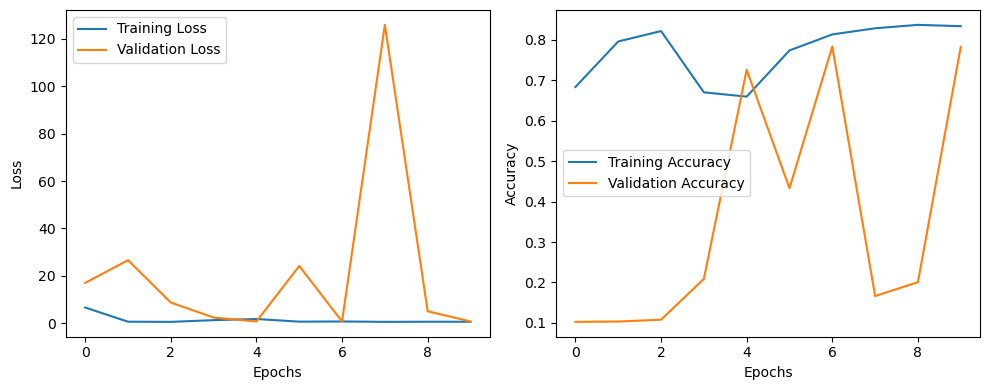

Training loss on best CNN model      : 0.720294134264191

Training accuracy on best CNN model  : 0.8137083333333334

Validation loss on best CNN model    : 0.7115503381888072

Validation accuracy on best CNN model: 0.7838333333333334



In [28]:
# Printing Best hyperparameters
print(f"Best hyperparameters:")
print('Convolutional block channels', best_hyperparameters['conv_block_channels'])
print("Optimizer:", best_hyperparameters['optimizer'])
print('Activation function', best_hyperparameters['activation_function'])



# Print the best model file path
best_model_path = 'best_cnn_model'+ str(best_model) + '.pth'
print(f"Best model path     : {best_model_path}\n\n")

# Plotting training history for the best FNN model
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_train_accuracies, label='Training Accuracy')
plt.plot(best_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Print training, validation losses and accuracies on best FNN model

print(f"Training loss on best CNN model      : {best_train_loss}\n")
print(f"Training accuracy on best CNN model  : {best_train_acc}\n")
print(f"Validation loss on best CNN model    : {best_val_loss}\n")
print(f"Validation accuracy on best CNN model: {best_val_acc}\n")


In [29]:
#Evaluating of best model on test dataset
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics


# Initialize your Convolution neural network class
model = CNN(best_hyperparameters['conv_block_channels'], best_hyperparameters['activation_function'])
# Load the saved best model weights
model.load_state_dict(torch.load(best_model_path))

test_loader = DataLoader(test_dataset, batch_size=best_hyperparameters['batch_size'], shuffle=False)

# Set the model to evaluation mode
model.eval()

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate the confusion matrix and accuracy
conf_matrix = confusion_matrix(true_labels, predictions)
print("Classification report for best CNN on test dataset :\n%s\n"
      % (metrics.classification_report(true_labels, predictions)))

print("\nConfusion Matrix on Test dataset:")
print(conf_matrix)

Classification report for best CNN on test dataset :
              precision    recall  f1-score   support

           0       0.55      0.91      0.69      1000
           1       0.98      0.95      0.97      1000
           2       0.67      0.66      0.67      1000
           3       0.81      0.80      0.81      1000
           4       0.81      0.44      0.57      1000
           5       0.98      0.70      0.82      1000
           6       0.44      0.46      0.45      1000
           7       0.81      0.95      0.87      1000
           8       0.97      0.92      0.94      1000
           9       0.94      0.93      0.94      1000

    accuracy                           0.77     10000
   macro avg       0.80      0.77      0.77     10000
weighted avg       0.80      0.77      0.77     10000



Confusion Matrix on Test dataset:
[[910   1   8  19   1   0  56   1   4   0]
 [ 14 953   0  31   0   0   1   0   1   0]
 [ 57   0 659  15  42   0 227   0   0   0]
 [130   9   1 804  23  

# Lab

In [ ]:
# Preparing FashionMNIST data with input size 1x28x28
transform = transforms.Compose([
    transforms.ToTensor(),  # No resizing needed, as FashionMNIST images are already 28x28
])

# Define a function to convert labels to one-hot encoding
def one_hot_encode_labels(labels, num_classes=10):
    return torch.eye(num_classes)[labels]

# Download FashionMNIST dataset
train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# # Modify the labels to one-hot encoding for both training and testing sets
# train_data.targets = one_hot_encode_labels(train_data.targets)
# test_data.targets = one_hot_encode_labels(test_data.targets)

# Define data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
print(train_data.shape)

In [ ]:

def images(f):
    with gzip.open(f, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images

def labels(f):
    with gzip.open(f, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [ ]:
training_images = images('train-images-idx3-ubyte.gz')
testing_images  = images('t10k-images-idx3-ubyte.gz')
training_labels = labels('train-labels-idx1-ubyte.gz')
testing_labels  = labels('t10k-labels-idx1-ubyte.gz')
print('Train: X=%s, y=%s' % (training_images.shape, training_labels.shape))
print('Test : X=%s, y=%s' % (testing_images.shape, testing_labels.shape))



In [ ]:
# Plot the PCA spectrum
plt.figure(figsize=(6, 4))
plt.plot(ratio_variance, linewidth=2)
plt.xlabel("Number of top features")
plt.ylabel("Variance captured by the top-k features")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Change integers to 32-bit floating point numbers and normalize to range of 0-1
X_train = training_images.astype('float32')/255
X_test  = testing_images.astype('float32')/255

# Splitting the training dataset to train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train, training_labels, stratify=training_labels, test_size=0.2, random_state=42)

print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('val  : X=%s, y=%s' % (X_val.shape, y_val.shape))
print('Test : X=%s, y=%s' % (X_test.shape, testing_labels.shape))

In [ ]:
import seaborn as sns
import pandas as pd

# Create separate Series for each dataset
y_train_series = pd.Series(y_train)
y_val_series = pd.Series(y_val)
testing_labels_series = pd.Series(testing_labels)

# Calculate value counts for each dataset
class_counts_train = y_train_series.value_counts()
class_counts_val = y_val_series.value_counts()
class_counts_test = testing_labels_series.value_counts()

# Plotting class distributions for each dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=class_counts_train.index, y=class_counts_train.values)
plt.title("Class distribution for Training dataset")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
sns.barplot(x=class_counts_val.index, y=class_counts_val.values)
plt.title("Class distribution for Validation dataset")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 3, 3)
sns.barplot(x=class_counts_test.index, y=class_counts_test.values)
plt.title("Class distribution for Test dataset")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [ ]:
# Flatten the images to 1-D by reshaping
X_train = X_train.reshape(48000,784)
X_val   = X_val.reshape(12000,784)
X_test  = X_test.reshape(10000,784)

print("Training matrix shape  :", X_train.shape)
print("Validation matrix shape:", X_val.shape)
print("Test matrix shape      :", X_test.shape)

In [ ]:
from sklearn.decomposition import PCA
pca_all = PCA(n_components = 784)
# Fit on training data
pca_fit = pca_all.fit_transform(X_train)
#percentage variance explained
ratio_variance = np.cumsum(pca_all.explained_variance_ratio_)
pca_fit.shape

In [ ]:
# Plot the PCA spectrum
plt.figure(figsize=(6, 4))
plt.plot(ratio_variance, linewidth=2)
plt.xlabel("Number of top features")
plt.ylabel("Variance captured by the top-k features")
plt.show()

In [ ]:
pca = PCA(n_components=0.95)
pca.fit(X_train)
pca.n_components_

In [ ]:
X_train_t = pca.transform(X_train)
X_val_t   = pca.transform(X_val)
X_test_t  = pca.transform(X_test)

X_train_i = pca.inverse_transform(X_train_t)
X_val_i   = pca.inverse_transform(X_val_t)
X_test_i  = pca.inverse_transform(X_test_t)


training_images         = X_train.reshape(48000,28,28)
reduced_training_images = X_train_i.reshape(48000,28,28)

In [ ]:
import matplotlib.pyplot as plt

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Randomly select 30 images from train dataset to visualize
num_images_to_display = 30
random_indexes = np.random.randint(0, X_train.shape[0], num_images_to_display)

# Create a figure with a grid of subplots
plt.figure(figsize=(8, 6))  # Adjust overall figure size

for i, index in enumerate(random_indexes, 1):
    # Original image
    plt.subplot(6, 10, i)
    plt.imshow(training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Original Images:", fontsize=10, color='blue')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')

    # Reduced image
    plt.subplot(6, 10, i + num_images_to_display)
    plt.imshow(reduced_training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Reduced Images:", fontsize=10, color='red')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')

# Adjust the placement of the title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_train_fnn = torch.tensor(X_train_t).float()
y_train_fnn = torch.tensor(y_train).long()
X_val_fnn   = torch.tensor(X_val_t).float()
y_val_fnn   = torch.tensor(y_val).long()
X_test_fnn  = torch.tensor(X_test_t).float()
y_test_fnn  = torch.tensor(testing_labels).long()

# Creating TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_fnn, y_train_fnn)
val_dataset   = TensorDataset(X_val_fnn, y_val_fnn)
test_dataset  = TensorDataset(X_test_fnn, y_test_fnn)

# Define the hyperparameters to tune
hyperparameters = {
    'num_hidden_layers': [1, 2, 3],
    'nodes_per_layer': [[187,64,10], [187,64,32,10], [187,64,32,16,10]],
    'activation_function': ['relu', 'tanh', 'leaky_relu'],
    'learning_rate': [0.001, 0.01, 0.1],
    'momentum': [0.0, 0.5, 0.9],
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30],
}

batch_size    = 32
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=batch_size)
test_loader   = DataLoader(test_dataset, batch_size=batch_size)

# Define the Feed-Forward Neural Network model
class FeedForwardNN(nn.Module):
    def __init__(self, num_hidden_layers, nodes_per_layer, activation_function, input_dim, output_dim):
        super().__init__()

        layers = []
        for i in range(num_hidden_layers):
            if i == 0:
                layers.append(nn.Linear(input_dim, nodes_per_layer))
            else:
                layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))

            if activation_function == 'relu':
                layers.append(nn.ReLU())
            elif activation_function == 'tanh':
                layers.append(nn.Tanh())
            elif activation_function == 'leaky_relu':
                layers.append(nn.LeakyReLU(0.1))

        layers.append(nn.Linear(nodes_per_layer, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, num_hidden_layers, nodes_per_layer, activation_function ):
        super().__init__()

        layers = []
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(nodes_per_layer[i], nodes_per_layer[i+1]))

            if activation_function == 'relu':
                layers.append(nn.ReLU())
            elif activation_function == 'tanh':
                layers.append(nn.Tanh())
            elif activation_function == 'leaky_relu':
                layers.append(nn.LeakyReLU(0.1))
        layers.append(nn.Linear(nodes_per_layer[nodes_per_layer[]], nodes_per_layer[i+1]))

model = SimpleNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 30
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train_preds = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train_preds += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    train_accuracy = correct_train_preds / len(train_dataset)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val_preds = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item() * val_inputs.size(0)

            _, predicted = torch.max(val_outputs, 1)
            correct_val_preds += (predicted == val_labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    val_accuracy = correct_val_preds / len(val_dataset)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_fnn_model.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {epoch_train_loss:.4f}, '
          f'Validation Loss: {epoch_val_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

# Plotting training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

# Load the trained FNN model
model = SimpleNN()  # Initialize your neural network class
model.load_state_dict(torch.load('best_fnn_model.pth'))  # Load the saved best model weights

# Set the model to evaluation mode
model.eval()

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate the confusion matrix and accuracy
conf_matrix = confusion_matrix(true_labels, predictions)
print("Classification report for FNN on test dataset :\n%s\n"
      % (metrics.classification_report(true_labels, predictions)))

print("\nConfusion Matrix on Test dataset:")
print(conf_matrix)

In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot


# Initialize the model
model = SimpleNN()

# Create a random input (batch size = 1, input features = 187)
x = torch.randn(1, 187)

# Visualize the model architecture using torchviz
output = model(x)
make_dot(output, params=dict(model.named_parameters()))


In [ ]:
!pip install torchviz